## Imports

In [1]:
import os
import sys
import pathlib

import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
# %load_ext watermark
# %watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

%load_ext autoreload
%autoreload 2

# Nice plot formating
%matplotlib inline

In [3]:
!ls

configs  Makefile    preprocess.py     src
data	 notebooks   README.md	       train_catalyst.py
logs	 predict.py  requirements.txt  train.py


## Explore data
### Train
- **68811** files in total
- **3097** folders with images

3088 classes, because some folders didn't contain any images (empty classes). Some other folders contained only 1 image. I manualy deleted them.

### Test A
- Number of queries: **9600**
- Library size: **49804**

### Test B
- Number of queries: **17092**
- Library size: **97547**

### Compute distribution of sizes

In [6]:
df = pd.read_csv("data/interim/train_val.csv")
df.head()

,file_path,label,original_size,aspect_ratio,is_query
0,DIGIX_000000/19BRS2LZXV4M865W.jpg,0,"(1080, 1440)",0.75,True
1,DIGIX_000000/4M83NC5JGYK0SP2Q.jpg,0,"(800, 800)",1.00,False
2,DIGIX_000000/5W97AIZ2CE43XHQD.jpg,0,"(800, 800)",1.00,False
3,DIGIX_000000/7WMZS8Q2V06E54FL.jpg,0,"(1368, 1824)",0.75,True
4,DIGIX_000000/9AYO2KC0ZLM3VU78.jpg,0,"(800, 800)",1.00,False


In [24]:
df_test = pd.read_csv("data/interim/test_A.csv")
df_test.head()

,file_path,original_size,aspect_ratio,is_query
0,gallery/0128JNE6U7OYQLRP.jpg,"(988, 654)",1.5107,0.0
1,gallery/01458WCN7FJAMLXP.jpg,"(729, 1296)",0.5625,0.0
2,gallery/015EGI4R893U6CTA.jpg,"(790, 683)",1.1567,0.0
3,gallery/015IB4PO73TSAGY8.jpg,"(1080, 1440)",0.7500,0.0
4,gallery/015VJEZKNTSDPM9F.jpg,"(1000, 1000)",1.0000,0.0


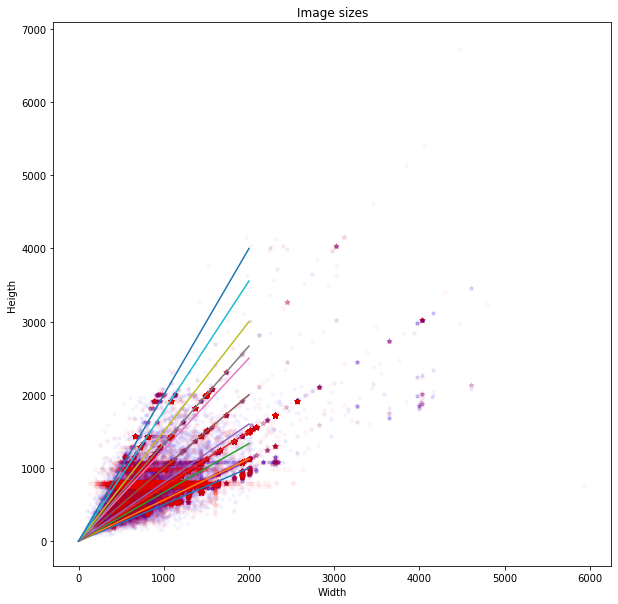

In [20]:
plt.figure(figsize=(10,10))
plt.title("Image sizes")
plt.xlabel("Width")
plt.ylabel("Heigth")


H = [eval(x)[0] for x in df["original_size"]]
W = [eval(x)[1] for x in df["original_size"]]
plt.scatter(W, H, marker='.', c='b', alpha=0.03)

H = [eval(x)[0] for x in df_test["original_size"]]
W = [eval(x)[1] for x in df_test["original_size"]]
plt.scatter(W, H, marker='*', c='r', alpha=0.03)

ap = [2, 16/9, 3/2, 4/3, 5/4, 1, 4/5, 3/4, 2/3, 9/16, 1/2]
x = np.arange(2000)

for aspect in ap:
    y = x / aspect
    
    plt.plot(x, y)

In [30]:
# Convert label.txt to DF
# Add info about original size
# Add info about aspect ratio
# Add info about query / not query

root = "data/interim"

# # Read file with labels
with open("data/raw/train_data/label.txt") as f:
    data = f.readlines()

filenames, targets = [], []
for row in data:
    path, label = row.strip("\n").split(",")
    filenames.append(path)
    targets.append(int(label))
    
targets[:10], filenames[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['DIGIX_000000/MSWZD6T13QJCNV9X.jpg',
  'DIGIX_000000/I18OVRJHK2U59BCY.jpg',
  'DIGIX_000000/MK7GUA9JLS8RO21X.jpg',
  'DIGIX_000000/UF26GP1XA8S4Y7ZJ.jpg',
  'DIGIX_000000/SUFP9IC751BADZLE.jpg',
  'DIGIX_000000/T1XJ8ZBWFC9PYR3U.jpg',
  'DIGIX_000000/PMQWS5BNO80FHIC3.jpg',
  'DIGIX_000000/4M83NC5JGYK0SP2Q.jpg',
  'DIGIX_000000/PIJ53Y4UB7ZW1DCQ.jpg',
  'DIGIX_000000/TGYOWRFUAN0J8X49.jpg'])

In [27]:
# def generate_size_info_df(paths, df) -> pd.DataFrame:
#     for path in tqdm(paths):
#         id_ = str(path).split('/')[-1].replace('.jpg', '')
#         img = cv2.imread(str(path))
#         h, w, c = img.shape
#         df.loc[id_, 'height'] = h
#         df.loc[id_, 'width'] = w
#     return df.reset_index().sort_values(by='id')


# # Read file with labels
# with open("data/raw/train_data/label.txt") as f:
#     data = f.readlines()

# self.filenames, self.targets = [], []
# for row in data:
#     path, label = row.strip("\n").split(",")
#     self.filenames.append(os.path.join(root, f"train_data_{size}", path))
#     self.targets.append(int(label))
# self.targets = torch.tensor(self.targets, dtype=torch.float)



import os.path
def sort_ar(valdir):
    idx2ar_file = valdir+'/../sorted_idxar.p'
    if os.path.isfile(idx2ar_file): return pickle.load(open(idx2ar_file, 'rb'))
    print('Creating AR indexes. Please be patient this may take a couple minutes...')
    val_dataset = datasets.ImageFolder(valdir) # AS: TODO: use Image.open instead of looping through dataset
    sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open(idx2ar_file, 'wb'))
    print('Done')
    return sorted_idxar

def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

def map_idx2ar(idx_ar_sorted, batch_size):
    ar_chunks = list(chunks(idx_ar_sorted, batch_size))
    idx2ar = {}
    for chunk in ar_chunks:
        idxs, ars = list(zip(*chunk))
        mean = round(np.mean(ars), 5)
        for idx in idxs: idx2ar[idx] = mean
    return idx2ar

NameError: name 'self' is not defined

### View images

In [4]:
from src.datasets import ClassificationDataset, get_dataloaders
from src.augmentations import get_aug

3088


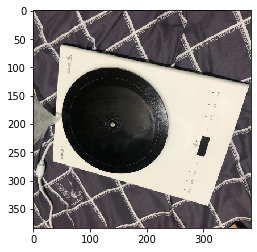

In [28]:
dataset = ClassificationDataset(root="data/interim", transform=None, train=True, size=384)
# plt.imshow(dataset[0][0])
# plt.subplot(1, 3, 3)
plt.imshow(dataset[2000][0].permute(2, 1, 0))

print(len(set(dataset.targets)))

In [29]:
len(set(dataset.targets))
3088
3097

3097

In [23]:
for i in tqdm(dataset):
    pass

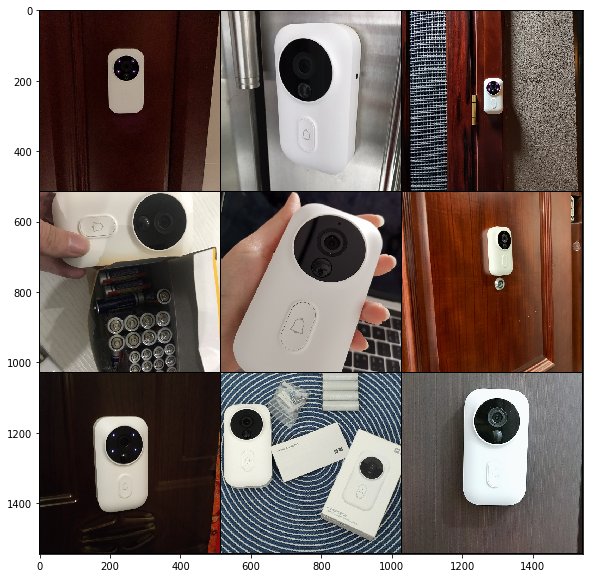

In [30]:
# Init dataset and plot 4 images with the same label to check, if label is correct
SIZE = 512
AUG = "val"

# Get augmentations
aug = get_aug(AUG, size=SIZE)

dataset = ClassificationDataset(root="data/interim", transform=aug, train=True, size=SIZE, val_pct=0.2)
# dataset = ClassificationDataset(root="data/interim", transform=None, train=True, size=SIZE, val_pct=0.2)

def plot_same_class(dataset, idx, N=4):
    image, target = dataset[idx]
    same_idx = torch.arange(len(dataset))[(torch.tensor(dataset.targets) == target)]
    # Filter initial index
    same_idx = same_idx[same_idx != idx]
    assert len(same_idx) > N, "Not enough images to take"
    images = [image]
    
    for i in range(N - 1):
        image, _ = dataset[same_idx[i]]
        images.append(image)
    
    images = torch.stack(images)

    grid = torchvision.utils.make_grid(images, nrow=3, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute((1,2,0)))


plot_same_class(dataset, idx=300, N=9)

In [31]:
from src.augmentations import get_aug
import torchvision

train_loader, val_loader = get_dataloaders(
    root="data/interim",
    augmentation="hard",
    batch_size=9,
    size=384,
    val_size=384,
    workers=6,
)

2020-09-16 21:15:47.642 | INFO     | src.datasets:get_val_dataloader:103 - Val size: 20641
2020-09-16 21:15:47.645 | INFO     | src.datasets:get_dataloaders:72 - Train size: 68805


In [25]:
for batch in tqdm(train_loader):
    train_images, labels = batch
    pass

In [ ]:
for batch in val_loader:
    val_images, labels = batch
    break
    

train_grid = torchvision.utils.make_grid(train_images, nrow=3, normalize=True, scale_each=True)
val_grid = torchvision.utils.make_grid(val_images, nrow=3, normalize=True, scale_each=True)
grid = torch.cat([train_grid, val_grid], dim=2)
plt.figure(figsize=(30, 10))
plt.imshow(grid.permute((1,2,0)).cpu())

albu.Cutout()

In [ ]:
len(torch.FloatTensor(10).uniform_() > 0.8)


## Implement metrics

### CMC score

In [49]:
_aspect_ratios = np.array([2, 16 / 9, 3 / 2, 4 / 3, 5 / 4, 1, 4 / 5, 3 / 4, 2 / 3, 9 / 16, 1 / 2])

df = pd.read_csv("data/interim/train_val.csv")
ar = df["aspect_ratio"].values
ar[:10]

array([0.75  , 1.    , 1.    , 0.75  , 1.    , 0.75  , 0.7486, 0.75  ,
       0.75  , 0.7486])

In [55]:
ar.reshape(-1, 1), _aspect_ratios.reshape(1, -1).shape

np.abs(_aspect_ratios.reshape(1, -1) - ar.reshape(-1, 1))
np.argmin(np.abs(_aspect_ratios.reshape(1, -1) - ar.reshape(-1, 1)), axis=1)

array([7, 5, 5, ..., 3, 2, 3])

In [4]:
sys.path.append("/home/zakirov/repoz/GPU-Efficient-Networks/")

import GENet

In [15]:
model = GENet.genet_normal(
    pretrained=True,
    num_classes=1000,
    root="/home/zakirov/repoz/GPU-Efficient-Networks/GENet_params")

# model.fc_linear = torch.nn.Linear(in_features=2560, out_features=512)
# torch.nn.init.xavier_uniform_(model.fc_linear.weight)

model.adptive_avg_pool.netblock = 

AdaptiveAvgPool2d(output_size=(1, 1))

# Predict test images

In [23]:
"""
1. Split all validation data on query / gallery and compute evaluation metrics on that set
2. Take test data and predict on it
"""
import os
import cv2
import time
import yaml
import argparse

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import pytorch_tools as pt
from loguru import logger

from src.datasets import get_val_dataloader
from src.callbacks import cmc_score_count, rank_map_score
from src.models import Model


CONFIG_PATH = "logs/resnet101_384_arcface_fp16_gem_light/"
OUTPUT_PATH = "data/processed"
TEST = False
TTA = False
TEST_VALIDATION = False

@torch.no_grad()
def predict_from_loader(model, loader):
    """Compute embeddings for each image in loader.
    Args:
        model: Model to use for prediction
        loader: torch.nn.DataLoader
    Returns:
        embeddings: Tensor of shape `len(dataset) x `embedding_size`
        labels: Class labels for each image
    """

    embeddings = []
    labels = []
    for batch in tqdm(loader):
        if isinstance(batch, list):
            images, _ = batch
        else:
            images = batch
        embeddings.extend(model(images).cpu())
    return torch.stack(embeddings)

In [25]:
# Check that folder exists
assert os.path.exists(CONFIG_PATH)

# Read config
with open(os.path.join(CONFIG_PATH, "config.yaml"), "r") as file:
    model_configs = yaml.load(file)
    
model_configs.update(vars(hparams))
hparams = argparse.Namespace(**model_configs)

# Get model
model = Model(arch=hparams.arch, model_params=hparams.model_params, embedding_size=hparams.embedding_size).cuda()
# logger.info(model)

# Init
checkpoint = torch.load(os.path.join(CONFIG_PATH, f"model.chpn"))
model.load_state_dict(checkpoint["state_dict"], strict=False)

if TTA:
    model = pt.tta_wrapper.TTA(
        model, rotation=[90, 180, 270], activation="sigmoid")


# -------------- Test model on validation dataset --------------
if TEST_VALIDATION:
    loader, val_labels = get_val_dataloader(
        root=hparams.root,
        augmentation="val",
        batch_size=hparams.batch_size,
        size=hparams.size,
        workers=hparams.workers,
        val_pct=1.0, # !!! 
    )
    # TODO: Add TTA here in predict function
    val_embeddings = predict_from_loader(model, loader)

    # Create random bitmask. 20% of the data used as a query
    # logger.info(f"Len emb: {len(val_embeddings)}. ")
    query_mask = torch.FloatTensor(len(val_embeddings)).uniform_() > 0.8

    # Shape (n_embeddings, embedding_dim)
    query_embeddings, gallery_embeddings = val_embeddings[query_mask], val_embeddings[~query_mask]
    query_labels, gallery_labels = val_labels[query_mask], val_labels[~query_mask]
    logger.info(f"Query size: {len(query_labels)}. Gallery size {len(gallery_labels)}")

    # Shape (query_size x gallery_size)
    conformity_matrix = query_labels.reshape(-1, 1) == gallery_labels

    # Matrix of pairwise cosin distances
    distances = torch.cdist(query_embeddings, gallery_embeddings)

    acc1 = cmc_score_count(distances, conformity_matrix, topk=1)
    cmc10 = cmc_score_count(distances, conformity_matrix, topk=10)
    map10 = rank_map_score(distances, conformity_matrix, topk=10)
    target_metric = 0.5 * acc1 + 0.5 * map10
    logger.info(
        f"Val: Acc@1 {acc1:0.5f}, CMC@10 {cmc10:0.5f}, mAP@10 {map10:0.5f}, target {target_metric:0.5f}")

# -------------- Predict on  test dataset  --------------
if TEST:
    loader, is_query = get_test_dataloader(
        root=hparams.root,
        batch_size=hparams.batch_size,
        size=hparams.size,
        workers=hparams.workers,
    )
    test_embeddings = predict_from_loader(model, loader)

    is_query = is_query.type(torch.bool)
    # Shape (n_embeddings, embedding_dim)
    query_embeddings, gallery_embeddings = test_embeddings[is_query], test_embeddings[~is_query]

    # Matrix of pairwise cosin distances
    distances = torch.cdist(query_embeddings, gallery_embeddings)

    # Select first 10 matches, because other values are not scored

    for f, line in zip(query_files, torch.argsort(distances)[:, :10]):
        print(gallery_files[line])
        print(line)

    # final csv should query_img,{gallery_img_list}.


# fold_predictions = predict_from_loader(model, loader)
# test_predictions.append(fold_predictions)

# # Ensemble predictions
# if hparams.test_hold_out:
#     holdout_predictons = torch.stack(holdout_predictons, dim=1)
#     classes = torch.tensor(classes)
#     # Apply averaging
#     # holdout_predictons = average_strategy(holdout_predictons)
#     holdout_predictons = holdout_predictons[:, 0]

#     AUC = roc_auc_score(classes.cpu().numpy(), holdout_predictons.cpu().numpy())
#     AP = average_precision_score(classes.cpu().numpy(), holdout_predictons.cpu().numpy())
#     print(f"{hparams.name}: AUC {AUC:0.5f}, AP {AP:0.5f}")

    # Save to csv
    # ...

# test_predictions = torch.stack(test_predictions, dim=1)
# test_predictions = average_strategy(test_predictions)
# test_predictions_binary = test_predictions > 0.5

# Save to csv
# df_data = {
# "image_name": image_names,
# "target": test_predictions_binary.type(torch.int)
# }
# df = pd.DataFrame(data=df_data)
# df.to_csv(os.path.join(OUTPUT_PATH, f'{hparams.name}_test.csv'), index=None)


NameError: name 'hparams' is not defined

In [28]:
NUM_EMBEDDINGS = 20

# Shape (n_embeddings, embedding_dim)
test_embeddings = torch.rand(NUM_EMBEDDINGS, 4)
is_query = torch.FloatTensor(NUM_EMBEDDINGS).uniform_() > 0.8

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = test_embeddings[is_query], test_embeddings[~is_query]



# Matrix of pairwise cosin distances
distances = torch.cdist(query_embeddings, gallery_embeddings)



# -------------
perm_matrix = torch.argsort(distances)
position_matrix = torch.argsort(perm_matrix)
conformity_matrix = conformity_matrix.type(torch.bool)

position_matrix[~conformity_matrix] = (
    topk + 1
)  # value large enough not to be counted

closest = position_matrix.min(dim=1)[0]
k_mask = (closest < topk).type(torch.float)
k_mask.mean().item()



# -----------
perm_matrix = torch.argsort(distances)
conformity_matrix = conformity_matrix.type(torch.double)

# Sort matrix and take first K columns
conformity_matrix = torch.gather(conformity_matrix, 1, perm_matrix)[:, :topk]

precision = torch.cumsum(conformity_matrix, dim=-1) * conformity_matrix / torch.arange(start=1, end=topk + 1)
average_precision = precision.sum(dim=-1) / conformity_matrix.sum(dim=-1)

# If no match found at first k elements, AP is 0
average_precision[average_precision.isnan()] = 0
average_precision.mean().item()

# distances
# Select first 10 matches, because other values are not scored

# for f, line in zip(query_files, torch.argsort(distances)[:, :10]):
#     print(gallery_files[line])
#     print(line)

tensor([[0.8862, 0.6305, 0.3907, 0.8546, 0.8395, 0.9348, 1.0183, 0.8148, 0.5559,
         0.7548, 0.3810, 0.9844, 0.4228, 0.8792, 1.0774, 0.5928],
        [0.9156, 0.7587, 0.4060, 0.5369, 0.6418, 0.5686, 0.9229, 0.7780, 0.6020,
         0.6326, 0.6570, 0.9853, 0.4092, 0.6220, 1.0375, 0.5934],
        [0.9860, 0.8424, 0.4816, 0.7692, 0.8195, 0.9198, 1.0414, 0.9061, 0.7452,
         0.6496, 0.5968, 0.9869, 0.5893, 0.9467, 1.2262, 0.7602],
        [1.0475, 0.6127, 0.7560, 1.1289, 1.2138, 0.9906, 0.8383, 0.7623, 0.2645,
         0.9299, 0.5257, 0.8096, 0.5696, 1.0329, 1.1311, 0.3860]])

In [30]:
p = pathlib.Path()
p.exists()

True

# Make submission

In [32]:
from loguru import logger
from src.callbacks import cmc_score_count, rank_map_score

In [65]:
CONFIG_PATH = pathlib.Path("logs/resnet101_384_arcface_fp16_gem_light/")
# Val: Acc@1 0.81258, CMC@10 0.92955, mAP@10 0.80109, target 0.80683. In reality it's 0.56
# Val: Acc@1 0.81585, CMC@10 0.89858, mAP@10 0.81930, target 0.81758. topk=10, alpha=0, include_self=True
# Val: Acc@1 0.81294, CMC@10 0.88368, mAP@10 0.81732, target 0.81513. topk=10, alpha=0, inclues_self=True, with post renorm
# Val: Acc@1 0.80422, CMC@10 0.88462, mAP@10 0.80870, target 0.80646. topk=10, alpha=0, include_self=False
CONFIG_PATH = pathlib.Path("logs/genet_normal_384_arcface_fp16_gem_light/") 
# Val: Acc@1 0.81018, CMC@10 0.92054, mAP@10 0.82022, target 0.81520
# Val: Acc@1 0.81294, CMC@10 0.88368, mAP@10 0.81732, target 0.81513. topk=10, alpha=0, inclues_self=True, with post renorm
CONFIG_PATH = pathlib.Path("logs/genet_normal_512_cosface_fp16_gem_light/") 
df = pd.read_csv(CONFIG_PATH / "train_val.csv")

In [66]:
val_embeddings = torch.tensor(list(map(eval, df["embeddings"].values)))

In [67]:
def data_based_augmentation(embeddings, top_k=10, alpha=2, include_self=True):
    """
    Args:
        embeddings (Tensor): original embeddings
        top_k (int): How many neighbours to use
        alpha (int): Power for neighbours reweighting
        include_self (bool): Flag to include original embed in new one
    """
    # Matrix of pairwise cosin distances
    distances = torch.cdist(embeddings, embeddings)
    # Nearest neighbours
    topk_vals, topk_ind = distances.neg().topk(top_k, dim=1)
    # Get weight
    cosine_dist = (2 - topk_vals.neg()) * 0.5 # cos = ((2 - l2_distances) / 2)
    cosine_weight = (cosine_dist ** alpha)[..., None] # N x TOPK -> N x TOPK x 1
    new_embedding = embeddings[topk_ind] * cosine_weight # N x TOPK x EMBED_SIZE * N x TOPK x 1
    if include_self:
        new_embedding = new_embedding.mean(dim=1)
    else:
        new_embedding = new_embedding[:, 1:].mean(dim=1)
    new_embedding /= torch.norm(new_embedding, dim=1)[..., None] # normalize again
    return new_embedding

In [71]:
val_embeddings = data_based_augmentation(old_val_embeddings, alpha=0, include_self=False)

In [72]:
query_mask = df["is_query"].values.astype(np.bool)
val_labels = df["label"].values

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = val_embeddings[query_mask], val_embeddings[~query_mask]

query_labels, gallery_labels = val_labels[query_mask], val_labels[~query_mask]
logger.info(f"Query size: {len(query_labels)}. Gallery size {len(gallery_labels)}")
del val_embeddings


# Shape (query_size x gallery_size)
conformity_matrix = query_labels.reshape(-1, 1) == gallery_labels

# Matrix of pairwise cosin distances
distances = torch.cdist(query_embeddings, gallery_embeddings)

conformity_matrix = torch.tensor(conformity_matrix)
distances = distances

acc1 = cmc_score_count(distances, conformity_matrix, topk=1)
cmc10 = cmc_score_count(distances, conformity_matrix, topk=10)
map10 = rank_map_score(distances, conformity_matrix, topk=10)
target_metric = 0.5 * acc1 + 0.5 * map10

logger.info(
    f"Val: Acc@1 {acc1:0.5f}, CMC@10 {cmc10:0.5f}, mAP@10 {map10:0.5f}, target {target_metric:0.5f}")

2020-09-16 22:49:06.526 | INFO     | __main__:<module>:8 - Query size: 13755. Gallery size 55050
2020-09-16 22:54:25.057 | INFO     | __main__:<module>:27 - Val: Acc@1 0.79905, CMC@10 0.86863, mAP@10 0.80440, target 0.80173


In [55]:
# CONFIG_PATH = pathlib.Path("logs/resnet101_384_arcface_fp16_gem_light/")
# CONFIG_PATH = pathlib.Path("logs/genet_normal_384_arcface_fp16_gem_light/")
# CONFIG_PATH = pathlib.Path("logs/genet_normal_384_cosface_fp16_gem_light/")
CONFIG_PATH = pathlib.Path("logs/genet_normal_512_cosface_fp16_gem_light/")

df_test = pd.read_csv(CONFIG_PATH / "test_A.csv")

In [56]:
test_embeddings = torch.tensor(list(map(eval, df_test["embeddings"].values)))
query_mask = df_test["is_query"].values.astype(np.bool)

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = test_embeddings[query_mask], test_embeddings[~query_mask]
query_files, gallery_files = df_test["file_path"].values[query_mask], df_test["file_path"].values[~query_mask]
logger.info(f"Query size: {len(query_embeddings)}. Gallery size {len(gallery_embeddings)}")
del test_embeddings

2020-09-16 17:35:00.297 | INFO     | __main__:<module>:7 - Query size: 9600. Gallery size 49804


In [57]:
# Matrix of pairwise cosin distances
distances = torch.cdist(query_embeddings, gallery_embeddings)
perm_matrix = torch.argsort(distances)

In [58]:
query_files, gallery_files = df_test["file_path"].values[query_mask], df_test["file_path"].values[~query_mask]
# query_embeddings, gallery_embeddings = test_embeddings[query_mask], test_embeddings[~query_mask]

In [59]:
def show_predictions(query_idx, query_files, gallery_files, perm_matrix, topk=10):
    """Plots predictions"""
    predictions = gallery_files[perm_matrix[:,: topk][query_idx]]
    query_file = query_files[query_idx]
#     print(os.path.join("data/interim/test_data_A_384", query_file))
    
    query = cv2.imread(os.path.join("data/interim/test_data_A_384", query_file))
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1, topk + 1, 1)
    plt.imshow(query)
    for i in range(topk - 1):
        image = cv2.imread(os.path.join("data/interim/test_data_A_384", predictions[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, topk + 1, i + 2)
        plt.imshow(image)

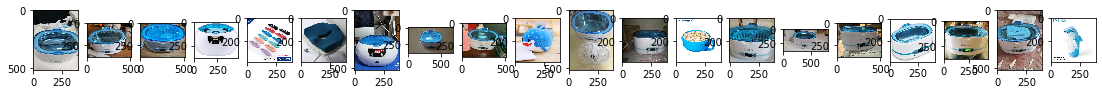

In [60]:
show_predictions(2, query_files, gallery_files, perm_matrix, topk=20)

In [61]:
data = {
    "image_id": [],
    "gallery_img_list": []
}

for idx in tqdm(range(len(query_files))):
    query_file = query_files[idx].split("/")[1]
    predictions = gallery_files[perm_matrix[:,: 10][idx]]
    predictions = [p.split("/")[1] for p in predictions]
    
    data["image_id"].append(query_file)
    data["gallery_img_list"].append(predictions)

    
# print(submission_data)
df = pd.DataFrame(data=data)
df["gallery_img_list"] = df["gallery_img_list"].apply(lambda x: '{{{}}}'.format(",".join(x))).astype(str)

lines = [f"{x},{y}" for x,y in zip(data["image_id"], df["gallery_img_list"])]

with open(CONFIG_PATH / "submission.csv", "w") as f:
    for line in lines:
        f.write(line + '\n')
        
# df = pd.DataFrame(data=df_data)
# # import csv
# df.to_csv(CONFIG_PATH / "submission.csv", index=None, header=False)
                                                      
